In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Sat Jun  4 17:32:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0    27W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import torch
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [6]:
import matplotlib.pyplot as plt
from utils import figure_8
from utils import net

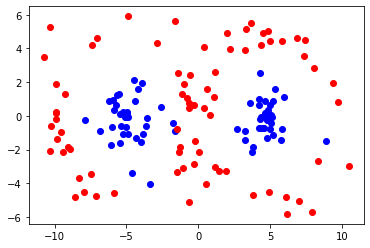

In [7]:
dataset = figure_8(150, var=2)
fig, ax = plt.subplots()
dataset.plot(ax)

In [14]:
net0 = net().to(device)

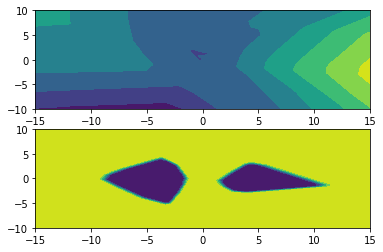

In [15]:
d = dataset.get_dataset()
fig, (ax1, ax2) = plt.subplots(2)
net0.plot_decision_boundary(ax1)
net0.train(d, 900)
net0.plot_decision_boundary(ax2)

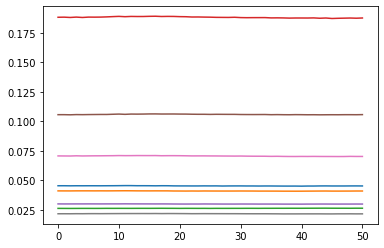

In [28]:
from positive_scaling_invariance import random_telep
from torch import nn
import numpy as np
import torch

net1 = net(with_bias=False).to(device)
repeats = 50
a, b = 0.5, 1.5

d = dataset.get_dataset()
data = d[:, 1:]
labels = d[:, :1]

outputs = np.empty(shape=(torch.numel(data[:, 0]),2, repeats+1))

outputs[:, :, 0] = net1.forward(data).detach().cpu().numpy()

for repeat in range(repeats):
  # for each teleportation, record both outputs values of each datapoint
  random_telep(net1, a, b)
  outputs[:, :, repeat+1] = net1(data).detach().cpu().numpy()

x = np.linspace(0, repeats, repeats+1)

for i in [1, 2, 20, 35, 50, 75, 100, 150] :
  plt.plot(x, outputs[i,0, :])
#  plt.plot(x, outputs[i,1, :])

In [30]:
import numpy as np
import torch
from torch  import nn
from torch.optim import Adam
from utils import SAM
from positive_scaling_invariance import random_telep

repeats = 50
a, b = 0.5, 1.5

d = dataset.get_dataset().to(device)
data = d[:, 1:]
labels = d[:, :1]

net2 = net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(net2.parameters())
minimizer = SAM(optimizer, net2, 0.5, 0.01)

res = np.empty(shape=(repeats+1,))
outputs = np.empty(shape=(torch.numel(data[:, 0]),2, repeats+1))


res[0] = minimizer.loss(data, labels, criterion)
outputs[:, :, 0] = net2.forward(data).detach().cpu().numpy()

for repeat in range(repeats):
  random_telep(net2, a, b)
  minimizer = SAM(optimizer, net2, 0.5, 0.01)
  res[repeat+1] = minimizer.loss(data, labels, criterion)

  outputs[:, :, repeat+1] = net2(data).detach().cpu().numpy()

fig, (ax1, ax2) = plt.subplots(2, figsize=(11, 11))

x = np.linspace(0, repeats, repeats+1)
ax1.plot(x, res)
for i in [1, 2, 20, 35, 50, 75, 100, 150] :
  ax2.plot(x, outputs[i,0, :])

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_mm)

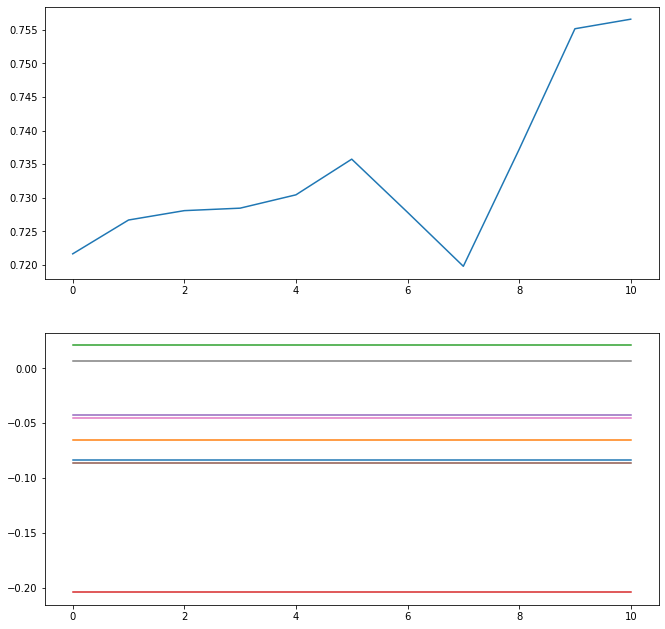

In [21]:
import numpy as np
import torch
from torch  import nn
from torch.optim import Adam
from utils import ASAM
from positive_scaling_invariance import random_telep

repeats = 10
a, b = 0.5, 1.5

d = dataset.get_dataset()
data = d[:, 1:]
labels = d[:, :1]

net3 = net()

criterion = nn.CrossEntropyLoss()
optimizer = Adam(net3.parameters())
minimizer = ASAM(optimizer, net3, 0.5, 0.01)

res = np.empty(shape=(repeats+1,))
outputs = np.empty(shape=(torch.numel(data[:, 0]),2, repeats+1))


res[0] = minimizer.loss(data, labels, criterion)
outputs[:, :, 0] = net3.forward(data).detach().numpy()

for repeat in range(repeats):
  random_telep(net3, a, b)
  minimizer = ASAM(optimizer, net3, 0.5, 0.01)
  res[repeat+1] = minimizer.loss(data, labels, criterion)

  outputs[:, :, repeat+1] = net3(data).detach().numpy()

fig, (ax1, ax2) = plt.subplots(2, figsize=(11, 11))

x = np.linspace(0, repeats, repeats+1)
ax1.plot(x, res)
for i in [1, 2, 20, 35, 50, 75, 100, 150] :
  ax2.plot(x, outputs[i,0, :])